<a href="https://www.kaggle.com/code/tanvirsiddikemoin/product-customer-recommendation-system?scriptVersionId=115938178" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import datetime
from pathlib import Path
import matplotlib.pyplot as plt

from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate

from sklearn.model_selection import train_test_split as  train_test_split_sklearn

In [2]:
def data_source():
    data_location = '../input/ecommerce-purchase-history-from-electronics-store/kz.csv'
    return pd.read_csv(data_location)

In [3]:
def login_successful(user_name, password):
    if user_name == 'test' and password == 'test':
        return True
    else:
        return False

In [4]:
def import_data():
    # Import raw data
    df_raw = data_source()
        
    print('Imported',f'{df_raw.shape[0]:,}','data points.')
    df_raw.drop_duplicates(subset=['order_id'],inplace=True)
    print('Dropping duplicate Order ID:',f'{df_raw.shape[0]:,}','data points remain.')

    # category_code and brand may be NaN
    df_clean = df_raw.dropna(subset=['event_time', 'order_id', 'product_id', 'category_id', 'price', 'user_id'])
    print('Scrubbing bad data:',f'{df_clean.shape[0]:,}','data points remain.')

    print('Formatting data.')
            
    # Data type and formatting
    df_all = df_clean.copy()
    df_all['event_time'] = pd.to_datetime(df_clean['event_time']).dt.date
    df_all['user_id'] = df_clean['user_id'].apply(lambda x: '%.f' % x)
    df_all['category_id'] = df_clean['category_id'].apply(lambda x: '%.f' % x)
    df_all['price'] = df_clean['price'].astype(float)
    return df_all.loc[df_all['event_time'] > datetime.date(2019, 12, 31),:]

In [5]:
def build_data_set(df_train):
    df_prod_user = (df_train[['product_id','user_id']]).copy()
    df_prod_user = df_prod_user.groupby(df_prod_user.columns.tolist(),as_index=False).size()
    df_prod_user.rename(columns={'size': 'rating'}, inplace=True)
    df_prod_user['rating'] = df_prod_user['rating'].apply(lambda x: x+1 if x < 3 else 4)
    
    df_prod = df_train['product_id'].drop_duplicates().sample(frac=.75)
    df_user = df_train['user_id'].drop_duplicates().sample(frac=.75)

    data_zero = pd.DataFrame(columns=['product_id','user_id'])
    data_zero['product_id'] = df_prod.copy()
    data_zero = pd.concat([data_zero, data_zero])
    data_zero = pd.concat([data_zero, data_zero])
    data_zero['user_id'] = data_zero['user_id'].apply(lambda x: df_user.sample().iloc[0])
    df = df_prod_user[['product_id','user_id']].copy()
    df_merge = pd.merge(data_zero,df)
    
    data_zero = data_zero[data_zero.product_id.isin(df_merge['product_id'].tolist()) == False]
    data_zero['rating'] = 1
    
    data_single = df_prod_user[df_prod_user['rating']==2].reset_index(drop= True)
    data_double = df_prod_user[df_prod_user['rating']==3].reset_index(drop= True)
    data_multiple = df_prod_user[df_prod_user['rating']==4].reset_index(drop= True)

    data_zero_train = data_zero.sample(int(0.33*(data_double.shape[0] + data_multiple.shape[0])))
    data_single_train, data_single_test = train_test_split_sklearn(data_single, train_size= 0.50)
    
    data_tuning = pd.concat([data_multiple, data_double, data_single_train, data_zero_train]).sort_values(by = 'rating').reset_index(drop=True)

    print('\nTraining Data:')
    print('Zero Purchases:.........', data_tuning[data_tuning['rating']==1].shape[0])
    print('Single Purchase:........', data_tuning[data_tuning['rating']==2].shape[0])
    print('Double Purchases:.......', data_tuning[data_tuning['rating']==3].shape[0])
    print('Multiple (3+) Purchases:', data_tuning[data_tuning['rating']==4].shape[0])
    print('Total Data Points:......', data_tuning.shape[0],'\n')
    
    return data_tuning

In [6]:
def rating_validation(df_valid,svd):
    df_purchases = df_valid.copy()
    df_purchases['SVD_rating'] = float(0)
    df_purchases['Deviation'] = float(0)

    for i,row in df_purchases.iterrows():
        p = row['product_id']
        u = row['user_id']
        SVDr = svd.predict(p,u).est
        d = abs(SVDr - float(row['rating']))
        if d < 0.01: d = 0
        df_purchases.at[i,'SVD_rating'] = SVDr
        df_purchases.at[i,'Deviation'] = d
    
    predictions = df_purchases[df_purchases['SVD_rating'] >= 2].shape[0]
    success = predictions * 100 / df_purchases['SVD_rating'].shape[0]
    
    print('\nPercent rated 2+:',format(success,'.2f'),'%')
    
    lt50 = df_purchases.loc[df_purchases['Deviation'] <= 0.50].shape[0]
    lt25 = df_purchases.loc[df_purchases['Deviation'] <= 0.25].shape[0]
    lt10 = df_purchases.loc[df_purchases['Deviation'] <= 0.10].shape[0]
    total = df_purchases.shape[0]
    print('Precent within +/-0.10:', format(100*lt10/total,'.2f'),'%')
    print('Precent within +/-0.25:', format(100*lt25/total,'.2f'),'%')
    print('Precent within +/-0.50:', format(100*lt50/total,'.2f'),'%')
    
    return df_purchases

In [7]:
def send_promotions_to(p, df_user, svd):
    ratings = pd.DataFrame(columns=['user_id','SVD_rating'])
    ratings['user_id'] = df_user.copy()
    ratings['SVD_rating'] = float(0)
    
    for i, row in ratings.iterrows():
        u = row['user_id']
        ratings.at[i,'SVD_rating'] = svd.predict(p,u).est
    
    ratings_2 = ratings[ratings['SVD_rating'] >= 2.0]
    ratings_2 = ratings_2.sort_values(by = 'SVD_rating',ascending=False).reset_index(drop=True)
    
    return ratings_2


In [8]:
# # Login
# print('Welcome to the KE Product to Customer Recommendation System.')
# user_name = input('User Name: ')
# password = getpass()
# 
# if not login_successful(user_name, password):
#     print('Incorrect User Name or Password.')
#     print('Exiting system.')
#     sys.exit()

In [9]:
# User Interface
print('Login successful.')
print('Please wait while the system imports data and generates the recommendation algorithm.\n')

Login successful.
Please wait while the system imports data and generates the recommendation algorithm.



In [10]:
#Import and clean data
df_all = import_data()

Imported 2,633,521 data points.
Dropping duplicate Order ID: 1,435,266 data points remain.
Scrubbing bad data: 389,709 data points remain.
Formatting data.


In [11]:
# Divide data into presale(train) and sale(valid) data
training_day = datetime.date(2020, 11, 1)
df_train = df_all.loc[df_all['event_time'] < training_day,:]
df_train = df_train.sort_values(by = 'event_time').reset_index(drop=True)

df_nov = df_all.loc[df_all['event_time'] >= training_day,:]
df_nov_product = df_nov['product_id']
df = df_all[df_all['product_id'].isin(df_nov_product.tolist()) == True]
df = df.sort_values(by = 'event_time').reset_index(drop=True)
df_valid = (df[['product_id','user_id']]).copy()
df_valid = df_valid.groupby(df_valid.columns.tolist(),as_index=False).size()
df_valid.rename(columns={'size': 'rating'}, inplace=True)
df_valid['rating'] = df_valid['rating'].apply(lambda x: x+1 if x < 3 else 4)

In [12]:
# SVD Prediction Algorithm
svd = SVD()
data_tuning = build_data_set(df_train)

reader = Reader(rating_scale=(1, 4))
data = Dataset.load_from_df(data_tuning, reader)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
trainset = data.build_full_trainset()
svd.fit(trainset)


Training Data:
Zero Purchases:......... 10247
Single Purchase:........ 133922
Double Purchases:....... 22244
Multiple (3+) Purchases: 8808
Total Data Points:...... 175221 

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5869  0.5887  0.5882  0.5813  0.5824  0.5855  0.0031  
MAE (testset)     0.4050  0.4088  0.4077  0.4035  0.4055  0.4061  0.0019  
Fit time          11.06   11.21   11.13   11.16   11.48   11.21   0.15    
Test time         0.33    0.50    0.30    0.30    0.30    0.35    0.08    


In [13]:
# User Interface
# df_products = df_all[['product_id', 'category_id', 'category_code', 'brand', 'price']].drop_duplicates(subset=['product_id'])
# df_user = df_train['user_id'].drop_duplicates()

# print('System is now ready to use.')
# print('Please input a product ID.')
# print('Type RANDOM for a random product ID.')
# print('Type EXIT to exit.')
# p_input = input('product ID: ')

# while p_input != 'EXIT':
#     p = pd.DataFrame()
#     if p_input == 'RANDOM':
#         p = df_products[df_products['product_id'] == df_nov_product.sample().iloc[0]]
#     elif p_input.isnumeric():
#         p = df_products[df_products['product_id'] == int(p_input)]
        
#     if p.empty:
#         print('Invalid entry, please try again')
#     else:
#         p_id = p['product_id'].iloc[0]
#         c_id = p['category_id'].iloc[0]
#         c_code = p['category_code'].iloc[0]
#         brand = p['brand'].iloc[0]
#         price = p['price'].iloc[0]
#         print('\nproduct_id:', p_id)
#         print('category_id:', c_id)
#         print('category_code:', c_code)
#         print('brand:', brand)
#         print('price: $%s' %price)
        
#         print('Finding customers....')
#         df_promotions = send_promotions_to(p_id, df_user, svd)
#         print('Top Ten Customers Most Likely to Purchase:')
#         print(df_promotions.head(10))
        
#         filepath = Path('output/' + str(p_id) + '.csv')  
#         filepath.parent.mkdir(parents=True, exist_ok=True)  
#         df_promotions.to_csv(filepath)
        
#         print('Full list has been exported to output folder.')
        
#     p_input = input('\nproduct ID: ')

In [14]:
# Validate prediction algorithm with sale data
df_purchases = rating_validation(df_valid,svd)


Percent rated 2+: 90.17 %
Precent within +/-0.10: 25.12 %
Precent within +/-0.25: 56.24 %
Precent within +/-0.50: 80.99 %


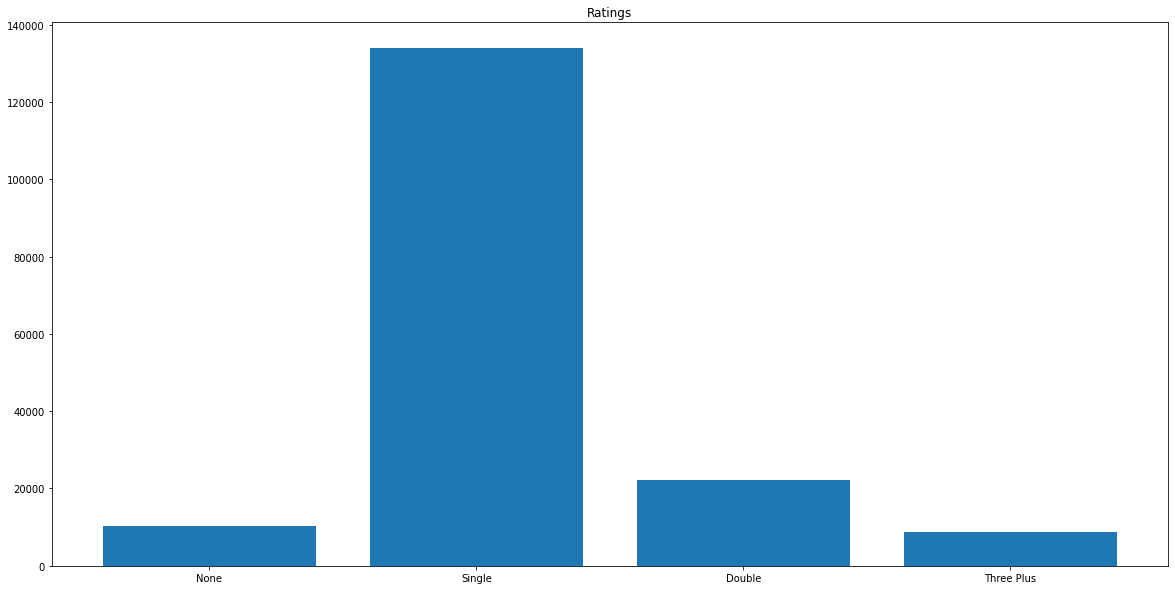

In [15]:
# Bar Plot of training data rating distribution
plt.figure(figsize= (20,10))
plt.bar(['None', 'Single','Double','Three Plus'],[data_tuning[data_tuning['rating']==1].shape[0]
                                                  ,data_tuning[data_tuning['rating']==2].shape[0]
                                                  ,data_tuning[data_tuning['rating']==3].shape[0]
                                                  ,data_tuning[data_tuning['rating']==4].shape[0]])
plt.title('Ratings')
plt.show()

<AxesSubplot:>

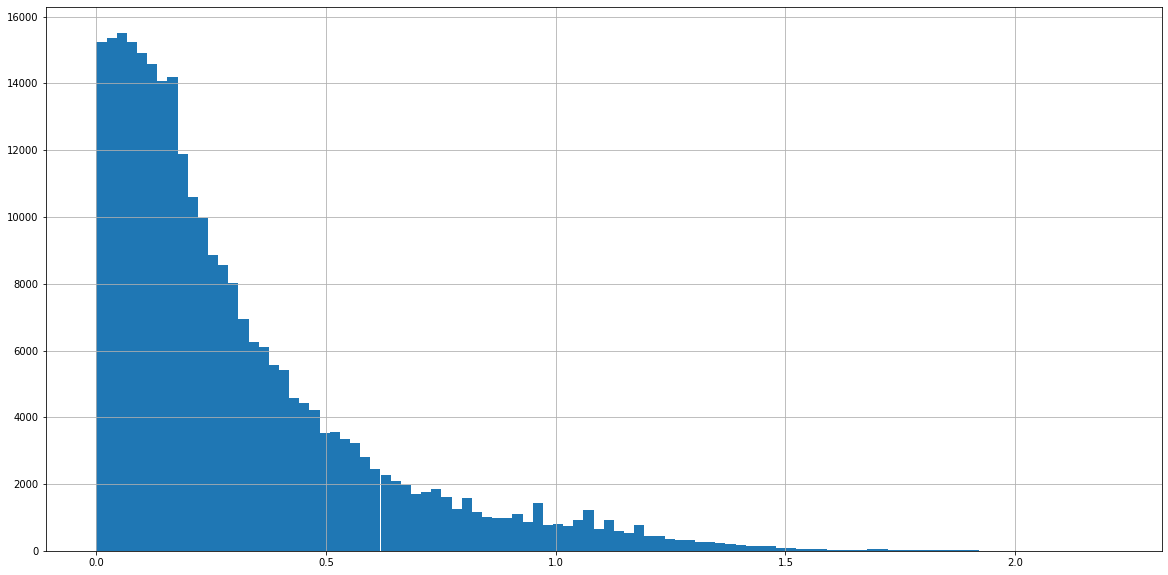

In [16]:
# Histogram of Deviations in November predictions
df_purchases['Deviation'].hist(bins= 100, figsize= (20,10))

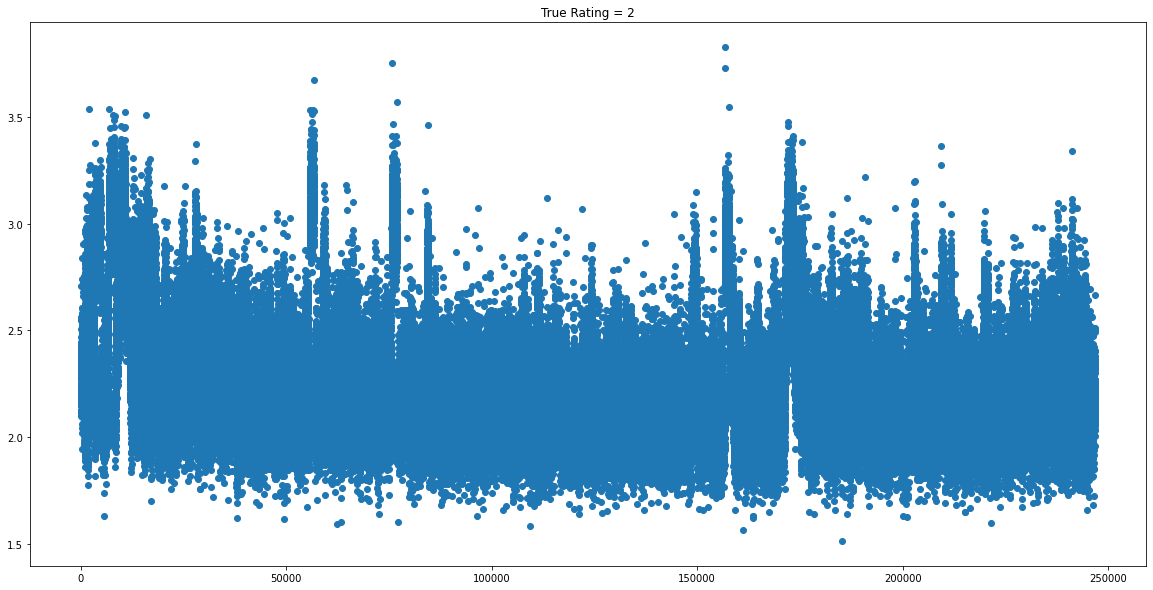

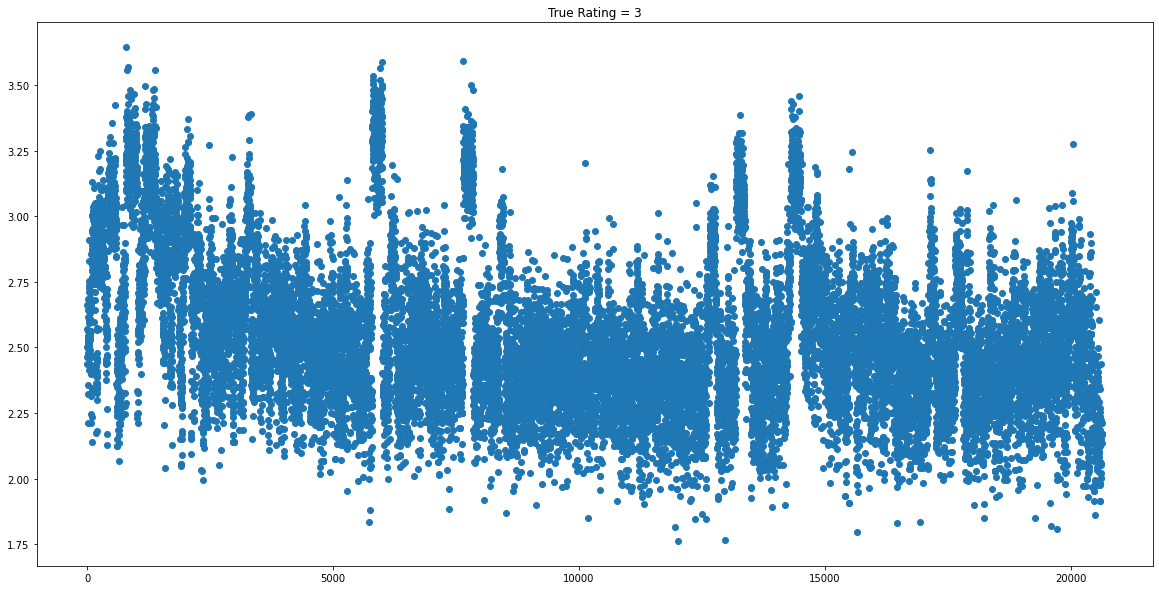

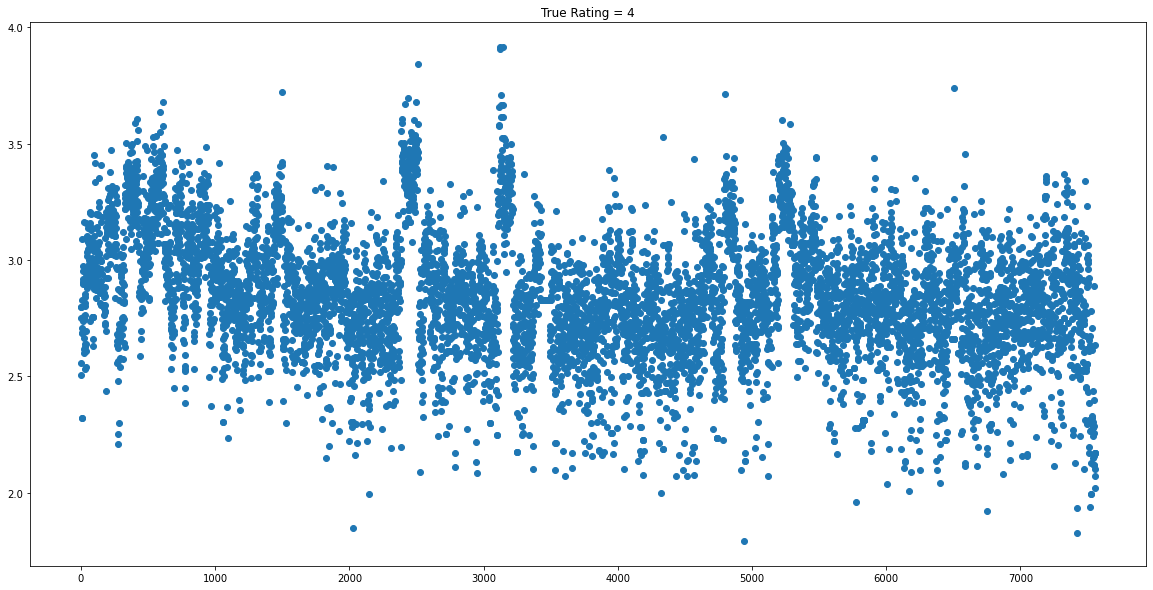

In [17]:
# Scatter Plots of True Ratings vs SVD Prediction Ratings
df_purchases_two = df_purchases[df_purchases['rating'] == 2].reset_index(drop=True)
df_purchases_three = df_purchases[df_purchases['rating'] == 3].reset_index(drop=True)
df_purchases_four = df_purchases[df_purchases['rating'] == 4].reset_index(drop=True)

x = df_purchases_two.index.values.tolist()
y = df_purchases_two['SVD_rating']
plt.figure(figsize= (20,10))
plt.scatter(x, y)
plt.title('True Rating = 2')
plt.show()

x = df_purchases_three.index.values.tolist()
y = df_purchases_three['SVD_rating']
plt.figure(figsize= (20,10))
plt.scatter(x, y)
plt.title('True Rating = 3')
plt.show()

x = df_purchases_four.index.values.tolist()
y = df_purchases_four['SVD_rating']
plt.figure(figsize= (20,10))
plt.scatter(x, y)
plt.title('True Rating = 4')
plt.show()